# RNN LSTM Chatbot project

In this project I'm creating a chatbot that is supposed to answer questions from the Stanford Questions & Answers dataset SQuAD1, using a sequence-to-sequence Encoder-Decoder recurrent neural network architecture in PyTorch.

To make the notebook more readable and the code more modular, all helper functions (data ingestion and preparation, data analysis, vocabulary creation) were moved to `modules`. 

The model for easier debugging is kept in the main notebook for now.



In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
from torchtext.datasets import SQuAD1

In [5]:
train, test = SQuAD1("root")

In [6]:
from modules.data import *

#get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data ingestion

* Data is loaded from the dataset into pandas dataframes: one for training, one for testing, 
* To keep the dataset size reasonable, only a sample of the questions/answers is taken

In [7]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [8]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

In [9]:
train_len = 25000
test_len = 3000

In [10]:
train_df = sample_df_num(train_df, train_len)

In [11]:
test_df = sample_df_num(test_df, test_len)

In [176]:
#train_df = sample_df_perc(train_df, 1)

In [12]:
train_df.shape, test_df.shape

((25000, 2), (3000, 2))

In [13]:
train_df.head(3)

,Question,Answer
0,Whitehead's education style was to teach what?,a relatively few important concepts
1,Who spoke about the dead and missing people on...,Wei Hong
2,"In 2001, how many Greek residents were not cit...","762,191"


## Vocabulary creation / Data preparation

Sentences (questions and answers) are converted into lists of tokens:
* all characters are made into lower case
* punctuation is removed
* stopwords (most common words that don't carry much additional meaning) are removed, but keeping question words (when, how, who, etc.)
* For questions stemming is applied to reduce number of words to just their "roots". For answers this step is skipped, to have full unstemmed words in the answers vocabulary
* Pairs question:answer are created from both train and test dataset, and words are added to two vocabularies: Q_vocab and A_vocab

In [14]:
# Example of the sequence processing

import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

In how many languages were students in institutions of higher education being educated in 1974?
['how', 'many', 'languages', 'students', 'institutions', 'higher', 'education', 'educated', '1974']
['how', 'mani', 'languag', 'student', 'institut', 'higher', 'educ', 'educ', '1974']


In [15]:
from modules.vocab import Vocab

In [16]:
for col, norm in zip(cols, ['stem', None]): # only questions get stemmed
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [17]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [18]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
2471,Which mammal is the smallest?,bumblebee bat,"[which, mammal, smallest]","[bumblebee, bat]"
7936,On what ABC program was an AFL game shown?,Wide World of Sports,"[what, abc, program, afl, game, shown]","[wide, world, sports]"
15890,Where does the herpes virus hide?,in nerves,"[where, herp, virus, hide]",[nerves]


In [19]:
# processed sequences columns names have '_tokens' suffix
cols_tokens = [f'{col}_tokens' for col in cols]

### Create pairs and add to the vocabularies

In [20]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [21]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [22]:
Q_vocab, A_vocab = Vocab(), Vocab()

### Words from both training and test datasets are added to the two vocabularies

In [23]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [24]:
Q_vocab.n_words, A_vocab.n_words, 

(15566, 20064)

In [25]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [26]:
# Answers vocabulary contains more words due to lack of stemming

Q_vocab.n_words, A_vocab.n_words 

(16685, 21642)

## Data analysis and further cleanup

To improve and reduce the dataset, some analysis is done to find and remove outliers:
* least common words (those that occur only once)
* answers that have less than one token (empty sequences)
* questions that have less than three tokens, as they're not really meaningful
* histograms are used to find the "long tail" of the dataset: longer sequences are rare, so I establish a threshold above which the dataframe row with either very long question or answer is dropped. This way most of the data is kept, and the sequences can be of reasonable length

In [27]:
from modules.stats import sentences_stats, histograms

In [28]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.42
	         median: 6.00
	         minimum: 1
	         maximum: 24)
Sentences in column Answer_tokens:
	         mean: 2.43
	         median: 2.00
	         minimum: 0
	         maximum: 22)


In [29]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.50
	         median: 6.00
	         minimum: 2
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.38
	         median: 2.00
	         minimum: 0
	         maximum: 18)


### Remove the least common words from the sentences

In [30]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [31]:
print(f'Questions vocabulary has {len(get_outliers(Q_vocab, outlier_threshold+1))} words that occur only once, answers vocabulary has {len(get_outliers(A_vocab, outlier_threshold+1))} such words')

Questions vocabulary has 8429 words that occur only once, answers vocabulary has 13314 such words


### Create lists of those words and remove them from the sequences

In [32]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [33]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [34]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [35]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.12
	         median: 6.00
	         minimum: 1
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 1.96
	         median: 1.00
	         minimum: 0
	         maximum: 21)


In [36]:
# tokenized & least common removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.20
	         median: 6.00
	         minimum: 1
	         maximum: 18)
Sentences in column Answer_tokens:
	         mean: 1.90
	         median: 1.00
	         minimum: 0
	         maximum: 18)


### Remove questions that have less than three words and answers that have less than one

In [37]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


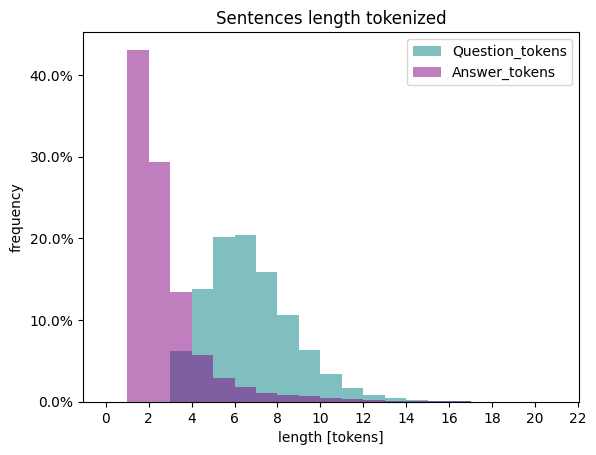

In [38]:
# display the histograms to see if that worked

train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [39]:
train_df_final.shape

(21261, 4)

In [40]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.23
	         median: 6.00
	         minimum: 3
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 2.24
	         median: 2.00
	         minimum: 1
	         maximum: 21)


In [41]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


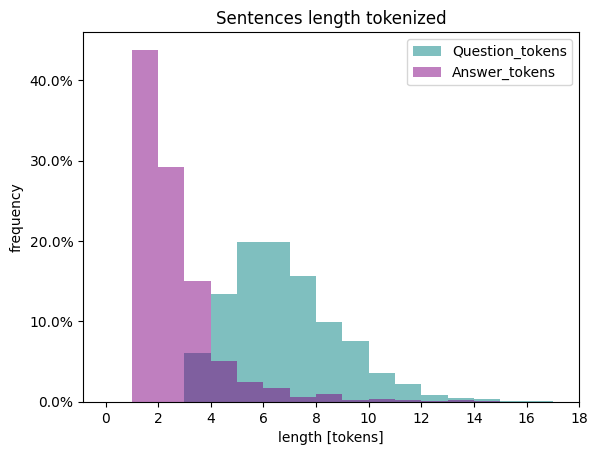

In [42]:
# display the histograms to see if that worked

test_df_final_thresholds = histograms(test_df_final, cols_tokens, name = 'tokenized')

In [43]:
test_df_final.shape

(2538, 4)

In [44]:
# shortest sentences removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.31
	         median: 6.00
	         minimum: 3
	         maximum: 18)
Sentences in column Answer_tokens:
	         mean: 2.16
	         median: 2.00
	         minimum: 1
	         maximum: 18)


### Remove long outliers: long sentences that occure rarely

In [45]:
# keeping only the 95% of the data
cutoff = 95

In [46]:
get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [47]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [48]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [49]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.04
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.98
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [ ]:
# to simplify I'm using the same thresholds for the test set

In [50]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [51]:
# long outliers removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.11
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.95
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [52]:
train_df_final.shape, test_df_final.shape

((19783, 4), (2366, 4))

### Pairs have to be redone from the cleaned up datasets, to be used in the model (after being turned into tensors).

In [53]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [54]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [55]:
len(train_pairs_final), len(test_pairs_final)

(19783, 2366)

In [56]:
type(train_pairs_final)

list

In [57]:
test_pairs_final[1]

Pair(question=['what', 'year', 'super', 'bowl', 'last', 'held', 'florida', 'area'], answer=['2010'])

In [102]:
def to_tensor_new(vocab, tokens, seq_len):
    '''Converts a tokenized sentence into a tensor of indices of a given length.
    If too short, it uses padding at the beginning of the sentence as suggested by the mentor.'''
    
    tokens = [t for t in tokens if t in vocab.word2count.keys()]
    
    #padded = [vocab.word2index['PAD']] * (seq_len-len(tokens)) + [vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']]

    padded = [vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']] + [vocab.word2index['PAD']] * (seq_len-len(tokens))
    
    tensor = torch.Tensor(padded).long().view(-1,1)
    
    return tensor

In [101]:
to_tensor_new(Q_vocab, test_df_final['Question_tokens'][1], Q_MAX)

tensor([[    1],
        [    7],
        [  186],
        [13951],
        [  299],
        [    2],
        [    0],
        [    0],
        [    0],
        [    0],
        [    0],
        [    0]])

In [103]:
Pair = namedtuple('Pair', ['question', 'answer'])
def get_tensor_pairs_from_df(df, cols, q_vocab, q_max_len, a_vocab, a_max_len):
    '''returns a list of named tuples (question, answer)'''
    dicts = []
    for col in cols:
        dicts.append(df[col].to_dict().values())
    
    return [Pair(to_tensor_new(q_vocab, q, q_max_len), to_tensor_new(a_vocab, a, a_max_len)) for q, a in zip(*dicts)]

In [104]:
train_tensor_pairs_final = get_tensor_pairs_from_df(train_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX)

In [105]:
test_tensor_pairs_final = get_tensor_pairs_from_df(test_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX)

# Another ChatGPT idea for the batch dataloader

In [106]:
from torch.utils.data import Dataset, DataLoader

In [107]:
class MyDataset(Dataset):
    def __init__(self, sequence):
        self.sequence = sequence
    
    def __len__(self):
        return len(self.sequence)
    
    def __getitem__(self, index):
        item = self.sequence[index]
        return item.question, item.answer
        
        

In [108]:
testdataset = MyDataset(test_tensor_pairs_final)

In [109]:
len(testdataset)

2366

In [110]:
testdataset[777]

(tensor([[   1],
         [   7],
         [  22],
         [1035],
         [ 186],
         [1713],
         [ 493],
         [   2],
         [   0],
         [   0],
         [   0],
         [   0]]),
 tensor([[   1],
         [1330],
         [   2],
         [   0],
         [   0],
         [   0],
         [   0],
         [   0]]))

In [111]:
batchsize = 4

In [112]:
testdataloader = DataLoader(testdataset, batch_size = batchsize, shuffle = False)

# DATALOADER FROM PYTORCH NLP TUTORIAL


https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

```python
def indexesFromSentence(lang, sentence):
    '''Converts a sentence into a list of indexes
    Inputs: language (vocabulary), sentence
    Outputs: list of indexes'''      
    return [lang.word2index[word] for word in sentence.split(' ')]
```

```python
def tensorFromSentence(lang, sentence):
    '''Converts a list of indexes into a tensor
    Inputs: language(vocabulary), sentence
    Output: Tensor of indexes, reshaped and moved to the device'''
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)
```

```python
def tensorsFromPair(pair):
    '''
    Create a tuple of tensors from a pair (in this case input language/output language
    '''    
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)
```

```python
def get_dataloader(batch_size):
    '''Create a dataloader
    
    * two arrays of zeros are created for source (input) and target data, the shape is number_of_pairs x max_lenght_sequence [in this example the length is the same!]
    * iterating over pairs:
        * sequences are converted into lists of indexes
        * EOS token is appended at the end
        * list of indexes is then written into the correct space in the empty array
        
    * train_data is created as an instance of TensorDataset (torch.data.utils class), which takes two tensors made of the two arrays
    * train_sampler is a RandomSampler of train_data
    * dataloader is created using train_data, train_sampler and batch_size
    
    '''
    
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)    
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader
```

# Train loop

```python
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)
```

### Data preparation for the neural network model

Sequences are converted into torch tokens made of their vocabulary indexes. Sequences shorter than the defined length are padded at the beginning. Also Start-Of-Sequence and End-Of-Sequence tokens are added to the tensor.

The padding token will be ignored by the model.

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



In [57]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    #def __init__(self, input_size, hidden_size, embedding_size , dropout = 0):
    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size
        #self.dropout = dropout

        #self.hidden = torch.zeros(1, 1, hidden_size)

        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        
        # The LSTM is our last cell because it produces the hidden state        
        #self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1, dropout = self.dropout).to(device)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)
        
        x = x.view(1, 1, -1)
        
        #x = x.view(x.shape[0], 1, -1)
        
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    #def __init__(self, hidden_size, output_size, embedding_size, dropout = 0):
    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        #self.dropout = dropout

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        #self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, dropout = self.dropout)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # The LSTM produces an output by passing the hidden state to the   Linear layer
    
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim= 1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

    
class Seq2Seq(nn.Module):

    #def __init__(self, encoder: Encoder, decoder: Decoder, device: torch.device):
    #def __init__(self, input_size, hidden_size, embedding_size, output_size, dropout, device):    
    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    
        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        #self.dropout = dropout
        
        #self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size, self.dropout).to(device)
        #self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size, self.dropout).to(device)
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
        #self.device = device
        
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        max_len, batch_size = trg_batch.shape
        
        print(f'Seq len: {max_len}, batch size {batch_size}, src_batch {src_batch.shape}, trg_batch {trg_batch.shape}')
                
        trg_vocab_size = self.decoder.output_size
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 

         # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)

        for i in range(src_len):
        
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        
        
        trg = trg_batch[0]
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

### Model parameters

In [58]:
embedding_dim = 256
hidden_size = 256
#dropout = 0.5

### Hyperparameters

In [59]:
learning_rate = 0.005
num_epochs = 50

### Model

In [60]:
#seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, dropout=dropout, device=device)
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [61]:
seq2seq = seq2seq.to(device)

### Optimizer and loss function

In [62]:
from torch import optim
import torch.nn as nn

In [63]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

### Model training 

For debugging purposes the training function is kept in the main notebook for now.

In [64]:
total_train_loss = []
total_test_loss = []

In [65]:
def train(model, pairs, optimizer, criterion, device, print_every = 1000):
    model.train()  # Set the model to training mode
    
    total_loss = 0

    count = 0
    
    for pair in pairs:
        
        src = pair.question
        tgt = pair.answer
        
        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        # print(src_tensor.shape, tgt_tensor.shape)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=1)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
        count += 1 
    
        if count % print_every == 0:
            print(f'Loss {total_loss/count}')
    
    return total_loss / len(pairs)

In [66]:
def evaluate(model, pairs, criterion, device):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
    
        for pair in pairs:
            
            src = pair.question
            tgt = pair.answer
            
            src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
            tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

            output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=0) # turn off teacher forcing

            # Compute the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

            
            total_loss += loss.item()
        
    return total_loss / len(pairs)

In [67]:
import matplotlib.pyplot as plt

# ITERATOR DATA LOADER TEST

As suggested by ChatGPT

In [69]:
from torch.utils.data import IterableDataset, DataLoader

In [70]:
class MyIterableDataset(IterableDataset):
    def __init__(self, data_iterator):
        self.data_iterator = data_iterator
        
    def __iter__(self):
        return self.data_iterator

In [74]:
class MyIterator:
    def __init__(self, data):
        self.data = data
    
    def __iter__(self):
        return self
    
    def __next__(self):
        batch = [self.data]
        if not batch:
            raise StopIteration
        
        return torch.tensor(batch)

In [75]:
data = [1,2,3,4,5]

In [76]:
iterator = MyIterator(data)

In [77]:
dataset = MyIterableDataset(iterator)

In [78]:
dataloader = DataLoader(dataset, batch_size = 2)

# WILL NEVER STOP

for batch in dataloader:
    print(batch)

In [68]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    test_loss = evaluate(seq2seq, test_pairs_final, criterion, device)    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)



Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
Seq len: 8, batch size 1, src_batch torch.Size([12, 1]

KeyboardInterrupt: 

Text(0, 0.5, 'loss')

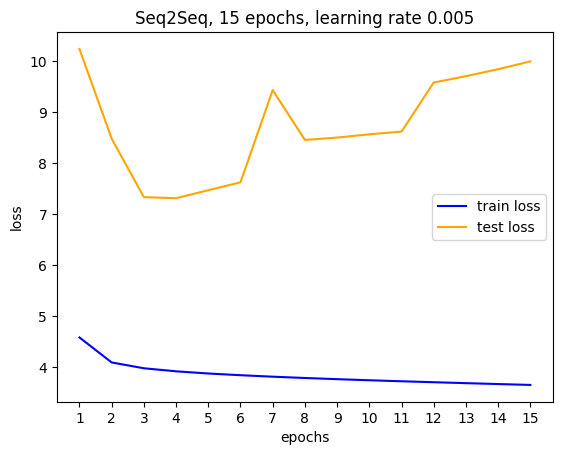

In [70]:
num_epochs = 15
fig, ax = plt.subplots()
ax.plot(range(1, num_epochs+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, num_epochs+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {num_epochs} epochs, learning rate {learning_rate}')
ax.set_xticks(range(1, num_epochs+1))
ax.set_xlim
ax.set_xlabel('epochs')
ax.set_ylabel('loss')